In [1]:
from github import Github, ContentFile
from github.Repository import Repository
import zipfile
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os

from typing import List

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger('urllib3').setLevel(logging.INFO)
logging.getLogger('github').setLevel(logging.INFO)
log = logging.getLogger(__name__)

In [3]:
GITHUB_TOKEN = os.getenv('GITHUB_PUBLIC_READ_TOKEN')
assert GITHUB_TOKEN is not None

In [4]:
CSV_PATH = 'CSV'
GITHUB_REPO = 'CSSEGISandData/COVID-19'

def get_csvs():
    g = Github(login_or_token=GITHUB_TOKEN)
    repo = g.get_repo(GITHUB_REPO)
    c = repo.get_contents('csse_covid_19_data/csse_covid_19_daily_reports')

    local_csvs = glob.glob(os.path.join(CSV_PATH, '*.csv'))
    local_csvs = list(map(os.path.basename, local_csvs))
    need_dowload = [f for f in c if f.path.endswith('.csv') and os.path.basename(f.path) not in local_csvs]
    for cf in need_dowload:
        fn = os.path.basename(cf.path)
        log.info(f'writing {fn}')
        with open(os.path.join(CSV_PATH, fn), 'wb') as f:
            f.write(cf.decoded_content)

In [5]:
get_csvs()

In [6]:
def path_to_date(path):
    path = os.path.basename(path)
    path = os.path.splitext(path)[0]
    date = pd.Timestamp(f'{path[-4:]}-{path[:2]}-{path[3:5]}')
    return date

def df_from_csv(path):
    column_info = {
        'FIPS': '',
        'Admin2': '',
        'Province_State': 'Province/State',
        'Country_Region': 'Country/Region',
        'Last_Update': 'Last Update',
        'Lat': 'Latitude',
        'Long_': 'Longitude',
        'Confirmed': 'Confirmed',
        'Deaths': 'Deaths',
        'Recovered': 'Recovered',
        'Active': '',
        'Combined_Key': '',
    }

    def combined_key(row):
        keys = ['Admin2', 'Province_State', 'Country_Region']
        values = [row[key] for key in keys]
        r = ', '.join((v for v in values if v and pd.notna(v)))
        return r

    log.debug(f'reading {path}')
    df = pd.read_csv(path)
    df['Date'] = path_to_date(path)
    column_names = list(df.columns)
    for column_name, old_column_name in column_info.items():
        if column_name in column_names:
            continue
        if old_column_name:
            if old_column_name in column_names:
                log.debug(f'{path}: renaming {old_column_name} to {column_name}')
                df.rename(columns={old_column_name: column_name}, inplace=True)
                continue
            else:
                log.debug(f'{path}: adding missing column {column_name}')
                df[column_name] = np.nan
                continue
        if column_name in ['FIPS', 'Admin2']:
            log.debug(f'{path}: adding missing column {column_name}')
            df[column_name] = np.nan
        elif column_name == 'Active':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']
        elif column_name == 'Combined_Key':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Combined_Key'] = df.apply(combined_key, axis=1)
        else:
            raise NotImplementedError(f'Unexpected column name: {column_name}')

    return df

In [7]:
csv_files = glob.glob(os.path.join(CSV_PATH, '*.csv'))
csv_files.sort(reverse=True)
covid = pd.concat(df_from_csv(csv_file) for csv_file in csv_files)

In [8]:
print(covid.columns)
covid.head(2)

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Date'],
      dtype='object')


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Date
0,45001.0,Abbeville,South Carolina,US,2020-04-18 22:32:47,34.223334,-82.461707,15.0,0.0,0.0,15.0,"Abbeville, South Carolina, US",2020-04-18
1,22001.0,Acadia,Louisiana,US,2020-04-18 22:32:47,30.295065,-92.414197,110.0,7.0,0.0,103.0,"Acadia, Louisiana, US",2020-04-18


Looks like 'China' and 'Mainland China' are (almost) equivalent. But the dates overlap

In [9]:
china = covid[covid.Country_Region=='China']
mainland_china = covid[covid.Country_Region=='Mainland China']
print(china.Province_State.unique())
print(mainland_china.Province_State.unique())
print(china.Date.describe())
print(mainland_china.Date.describe())

['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']
['Gansu' 'Hebei' 'Hubei' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui'
 'Jiangxi' 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang'
 'Beijing' 'Shanghai' 'Fujian' 'Guangxi' 'Shaanxi' 'Yunnan' 'Hainan'
 'Guizhou' 'Tianjin' 'Shanxi' 'Liaoning' 'Jilin' 'Xinjiang'
 'Inner Mongolia' 'Ningxia' 'Qinghai' 'Tibet']
count                    1287
unique                     39
top       2020-03-16 00:00:00
freq                       33
first     2020-03-11 00:00:00
last      2020-04-18 00:00:00
Name: Date, dtype: object
count                    1517
unique                     51
top       2020-01-31 00:00:00
freq                       31
first     2020-01-22

Take a look at the 'Mainland China' records which overlap with the 'China' records

In [10]:
first_china = china.Date.min()
print(f"'China' records start at {first_china}")
overlapping_mainland = mainland_china[mainland_china.Date>=first_china]
print(overlapping_mainland)

'China' records start at 2020-03-11 00:00:00
     FIPS Admin2 Province_State  Country_Region          Last_Update      Lat  \
211   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
212   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   
206   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
207   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   

        Long_  Confirmed  Deaths  Recovered  Active           Combined_Key  \
211  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
212  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   
206  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
207  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   

          Date  
211 2020-03-12  
212 2020-03-12  
206 2020-03-11  
207 2020-03-11  


Looks like the 'Mainland China' records which overlap with the 'China' records don't have numbers for Confirmed, Deaths, Recovered, or Active. We might as well get rid of them and then rename 'Mainland China' to 'China'

In [11]:
covid.drop(covid[(covid.Country_Region=='Mainland China') & (covid.Date>=first_china)].index, inplace=True)
covid.loc[covid.Country_Region=='Mainland China', 'Country_Region'] = 'China'

Also 'South Korea" and 'Korea, South' seem to be redundant. But there is no overlap

In [12]:
s_korea = covid[covid.Country_Region == 'South Korea']
ro_korea = covid[covid.Country_Region == 'Republic of Korea']
korea_s = covid[covid.Country_Region == 'Korea, South']
print('s_korea:')
print(s_korea.Date.describe())
print('ro_korea:')
print(ro_korea.Date.describe())
print('korea_s:')
print(korea_s.Date.describe())


s_korea:
count                      48
unique                     48
top       2020-02-17 00:00:00
freq                        1
first     2020-01-22 00:00:00
last      2020-03-09 00:00:00
Name: Date, dtype: object
ro_korea:
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object
korea_s:
count                      39
unique                     39
top       2020-03-13 00:00:00
freq                        1
first     2020-03-11 00:00:00
last      2020-04-18 00:00:00
Name: Date, dtype: object


Replace 'South Korea' and 'Republic of Korea' with 'Korea, South'

In [13]:
covid.loc[covid.Country_Region.isin(['South Korea', 'Republic of Korea']), 'Country_Region'] = 'Korea, South'

Finally 'Iran' and 'Iran (Islamic Republic of)' seem to be redundant

In [14]:
iran = covid[covid.Country_Region == 'Iran']
iran_r= covid[covid.Country_Region == 'Iran (Islamic Republic of)']
print(iran.Date.describe())
print(iran_r.Date.describe())

count                      59
unique                     59
top       2020-03-13 00:00:00
freq                        1
first     2020-02-19 00:00:00
last      2020-04-18 00:00:00
Name: Date, dtype: object
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object


In [15]:
covid.loc[covid.Country_Region == 'Iran (Islamic Republic of)', 'Country_Region'] = 'Iran'

In [16]:
# set defaults for Deaths, Recovered, and Confirmed
for c in ['Deaths', 'Recovered', 'Confirmed']:
    covid[c].fillna(value=0, inplace=True)

covid.Active.fillna(covid.Confirmed - covid.Deaths - covid.Recovered, inplace = True)

In [17]:
active_wrong = covid[covid.Active != (covid.Confirmed-covid.Deaths-covid.Recovered)]
active_wrong

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Date
1811,12091.0,Okaloosa,Florida,US,2020-04-13 23:07:54,30.691430,-86.592671,103.0,1.0,0.0,102102.0,"Okaloosa, Florida, US",2020-04-13
0,45001.0,Abbeville,South Carolina,US,2020-04-11 22:45:33,34.223334,-82.461707,9.0,0.0,0.0,0.0,"Abbeville, South Carolina, US",2020-04-11
1,22001.0,Acadia,Louisiana,US,2020-04-11 22:45:33,30.295065,-92.414197,98.0,4.0,0.0,0.0,"Acadia, Louisiana, US",2020-04-11
2,51001.0,Accomack,Virginia,US,2020-04-11 22:45:33,37.767072,-75.632346,15.0,0.0,0.0,0.0,"Accomack, Virginia, US",2020-04-11
3,16001.0,Ada,Idaho,US,2020-04-11 22:45:33,43.452658,-116.241552,513.0,6.0,0.0,0.0,"Ada, Idaho, US",2020-04-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186,NaN,NaN,Prince Edward Island,Canada,3/22/20 23:48,46.510700,-63.416800,3.0,0.0,0.0,0.0,"Prince Edward Island, Canada",2020-03-22
3187,NaN,NaN,Northwest Territories,Canada,3/22/20 23:48,NaN,NaN,1.0,0.0,0.0,0.0,"Northwest Territories, Canada",2020-03-22
3188,NaN,NaN,Diamond Princess,Canada,3/22/20 23:48,0.000000,0.000000,0.0,1.0,0.0,0.0,"Diamond Princess, Canada",2020-03-22
3415,11001.0,District of Columbia,District of Columbia,US,3/22/20 23:45,38.904178,-77.016560,102.0,2.0,0.0,0.0,"District of Columbia,District of Columbia,US",2020-03-22


In [18]:
covid.Active = covid.Confirmed-covid.Deaths-covid.Recovered

We only want to work on sums per country and date and the dataframe will be indexed by country and date


In [19]:
covid = covid.drop(columns=['FIPS', 'Lat', 'Long_']).groupby(by=['Country_Region', 'Date']).sum()

In [20]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8758 entries, (' Azerbaijan', Timestamp('2020-02-28 00:00:00')) to ('occupied Palestinian territory', Timestamp('2020-03-17 00:00:00'))
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Confirmed  8758 non-null   float64
 1   Deaths     8758 non-null   float64
 2   Recovered  8758 non-null   float64
 3   Active     8758 non-null   float64
dtypes: float64(4)
memory usage: 302.0+ KB


In [21]:
covid.head()

Confirmed  Deaths  Recovered  Active
Country_Region Date                                            
 Azerbaijan    2020-02-28        1.0     0.0        0.0     1.0
Afghanistan    2020-02-24        1.0     0.0        0.0     1.0
               2020-02-25        1.0     0.0        0.0     1.0
               2020-02-26        1.0     0.0        0.0     1.0
               2020-02-27        1.0     0.0        0.0     1.0

Get top n impacted countries

In [22]:
N_TOP_IMPACTED = 50
top_impacted = covid.groupby(level=0).max().Confirmed.nlargest(n=N_TOP_IMPACTED).index
top_impacted

Index(['US', 'Spain', 'Italy', 'France', 'Germany', 'United Kingdom', 'China',
       'Turkey', 'Iran', 'Belgium', 'Russia', 'Brazil', 'Canada',
       'Netherlands', 'Switzerland', 'Portugal', 'India', 'Ireland', 'Austria',
       'Peru', 'Sweden', 'Israel', 'Korea, South', 'Japan', 'Chile', 'Ecuador',
       'Poland', 'Romania', 'Saudi Arabia', 'Pakistan', 'Denmark', 'Norway',
       'Mexico', 'Czechia', 'Australia', 'United Arab Emirates', 'Indonesia',
       'Philippines', 'Serbia', 'Singapore', 'Malaysia', 'Ukraine', 'Qatar',
       'Belarus', 'Dominican Republic', 'Panama', 'Finland', 'Luxembourg',
       'Colombia', 'South Africa'],
      dtype='object', name='Country_Region')

Get population data. Data from https://data.worldbank.org/indicator/sp.pop.totl

In [23]:
def read_population():
    zip_files = glob.glob('API_SP*.zip')
    assert len(zip_files) == 1
    with zipfile.ZipFile(file=zip_files[0]) as zip_file:
        names = zip_file.namelist()
        data_file_name = next((n for n in names if n.startswith('API_SP')), None)
        assert data_file_name is not None
        with zip_file.open(data_file_name) as data_file:
            df = pd.read_csv(data_file, header=2)

    # drop empty columns
    df = df.dropna(axis='columns', how='all')

    # get value from last population column w/ non NaN value
    df['population'] = df.loc[:,'1960':].copy().ffill(axis=1).iloc[:, -1]

    # remove rows where we don't have a population value
    df = df[df.population.notnull()]

    # we only really need two columns
    df = df.loc[:, ['Country Name', 'population']]
    
    df = df.set_index('Country Name')


    return df

def read_population_un():
    """
    read population data obtained from https://population.un.org/wpp/Download/Standard/CSV/
    :return:
    """
    df = pd.read_csv('WPP2019_TotalPopulationBySex.csv', header=0)
    df = df[df.Time==2019]
    df = df.set_index('Location')
    df['population'] = df.PopTotal * 1000
    return df

population = read_population_un()
population.info()


<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, Afghanistan to Zimbabwe
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LocID       477 non-null    int64  
 1   VarID       477 non-null    int64  
 2   Variant     477 non-null    object 
 3   Time        477 non-null    int64  
 4   MidPeriod   477 non-null    float64
 5   PopMale     443 non-null    float64
 6   PopFemale   443 non-null    float64
 7   PopTotal    477 non-null    float64
 8   PopDensity  477 non-null    float64
 9   population  477 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 41.0+ KB


In [24]:
population.loc['Germany']

LocID                276
VarID                  2
Variant           Medium
Time                2019
MidPeriod         2019.5
PopMale          41249.1
PopFemale        42267.9
PopTotal           83517
PopDensity       239.606
population    8.3517e+07
Name: Germany, dtype: object

We want to relate the numbers of the top impacted countries to their population.

Do we have population data for all top impacted countries?

In [25]:
missing_countries = [c for c in top_impacted if c not in population.index]
missing_countries

['US', 'Iran', 'Russia', 'Korea, South']

In [26]:
print('\n'.join(c for c in population.index if 'United States' in c))
print()
print('\n'.join(c for c in population.index if 'Iran' in c))
print()
print('\n'.join(c for c in population.index if 'Russia' in c))
print()
print('\n'.join(c for c in population.index if 'Korea' in c))

United States Virgin Islands
United States of America
United States of America (and dependencies)

Iran (Islamic Republic of)

Russian Federation

Dem. People's Republic of Korea
Republic of Korea


Looks like we can use
* 'United States of America' for 'US'
* 'Iran (Islamic Republic of)' for 'Iran'
* 'Russian Federation' for 'Russia'
* 'Republic of Korea' for 'Korea, South'

For simplicity reasons we simply change the values in the population dataset

In [27]:
mapper = {
    'United States of America': 'US',
    'Iran (Islamic Republic of)': 'Iran',
    'Russian Federation': 'Russia',
    'Republic of Korea': 'Korea, South'}
population.rename(mapper=mapper, inplace=True)
missing_countries = [c for c in top_impacted if c not in population.index]
assert not missing_countries, f'missing: {missing_countries}'

Continue to work only with these top impacted countries.

In [28]:
covid = covid.loc[top_impacted]

Add values relative to population size

In [29]:
for c in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    covid[f'{c}_per_100k'] = covid[c] / population.loc[covid.index.get_level_values('Country_Region')].PopTotal.values * 100

In [30]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3088 entries, ('Australia', Timestamp('2020-01-23 00:00:00')) to ('United Kingdom', Timestamp('2020-04-18 00:00:00'))
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Confirmed           3088 non-null   float64
 1   Deaths              3088 non-null   float64
 2   Recovered           3088 non-null   float64
 3   Active              3088 non-null   float64
 4   Confirmed_per_100k  3088 non-null   float64
 5   Deaths_per_100k     3088 non-null   float64
 6   Recovered_per_100k  3088 non-null   float64
 7   Active_per_100k     3088 non-null   float64
dtypes: float64(8)
memory usage: 204.7+ KB


In [31]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Australia      2020-01-23        0.0     0.0        0.0     0.0   
               2020-01-25        4.0     0.0        0.0     4.0   
               2020-01-26        4.0     0.0        0.0     4.0   
               2020-01-27        5.0     0.0        0.0     5.0   
               2020-01-28        5.0     0.0        0.0     5.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Australia      2020-01-23            0.000000              0.0   
               2020-01-25            0.015871              0.0   
               2020-01-26            0.015871              0.0   
               2020-01-27            0.019839              0.0   
               2020-01-28            0.019839              0.0   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Australia      2020-01-23                 0.0         0.000000  
               2020-01-25                 0.0         0.015871  
               2020-01-26                 0.0         0.015871  
               2020-01-27                 0.0         0.019839  
               2020-01-28                 0.0         0.019839

In [32]:
covid_max = covid.groupby(level='Country_Region').max()
covid_max['population'] = population.loc[covid_max.index].PopTotal * 1000
covid_max['recovered_per_confirmed'] = covid_max.Recovered / covid_max.Confirmed
covid_max['deaths_per_confirmed'] = covid_max.Deaths / covid_max.Confirmed
covid_max.info()
covid_max

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Australia to United Kingdom
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Confirmed                50 non-null     float64
 1   Deaths                   50 non-null     float64
 2   Recovered                50 non-null     float64
 3   Active                   50 non-null     float64
 4   Confirmed_per_100k       50 non-null     float64
 5   Deaths_per_100k          50 non-null     float64
 6   Recovered_per_100k       50 non-null     float64
 7   Active_per_100k          50 non-null     float64
 8   population               50 non-null     float64
 9   recovered_per_confirmed  50 non-null     float64
 10  deaths_per_confirmed     50 non-null     float64
dtypes: float64(11)
memory usage: 4.7+ KB


,Confirmed,Deaths,Recovered,Active,Confirmed_per_100k,Deaths_per_100k,Recovered_per_100k,Active_per_100k,population,recovered_per_confirmed,deaths_per_confirmed
Country_Region,,,,,,,,,,,
Australia,6547.0,67.0,4124.0,4895.0,25.976860,0.265839,16.363002,19.422137,2.520320e+07,0.629907,0.010234
Austria,14671.0,443.0,10214.0,9334.0,163.828287,4.946897,114.057809,104.231015,8.955108e+06,0.696203,0.030196
Belarus,4779.0,45.0,342.0,4395.0,50.558540,0.476069,3.618125,46.496084,9.452409e+06,0.071563,0.009416
Belgium,37183.0,5453.0,8348.0,23382.0,322.228525,47.255793,72.343913,202.628819,1.153933e+07,0.224511,0.146653
Brazil,36658.0,2354.0,14026.0,21929.0,17.369383,1.115378,6.645834,10.390452,2.110495e+08,0.382618,0.064215
Canada,34356.0,1400.0,10964.0,21992.0,91.833859,3.742211,29.306859,58.784790,3.741104e+07,0.319129,0.040750
Chile,9730.0,126.0,4035.0,5569.0,51.340133,0.664836,21.290590,29.384707,1.895204e+07,0.414697,0.012950
China,83787.0,4636.0,78401.0,58046.0,5.843769,0.323340,5.468119,4.048449,1.433784e+09,0.935718,0.055331
Colombia,3439.0,153.0,634.0,2652.0,6.831621,0.303937,1.259450,5.268235,5.033944e+07,0.184356,0.044490


In [33]:
covid_max.sort_values(by='Confirmed',ascending=False).loc[:,['Confirmed', 'Deaths']]

,Confirmed,Deaths
Country_Region,,
US,731811.0,38645.0
Spain,191726.0,20043.0
Italy,175925.0,23227.0
France,149149.0,19345.0
Germany,143342.0,4459.0
United Kingdom,115314.0,15498.0
China,83787.0,4636.0
Turkey,82329.0,1890.0
Iran,80868.0,5031.0


In [34]:
covid_max.sort_values(by='Confirmed_per_100k',ascending=False).loc[:,['Confirmed_per_100k', 'Confirmed', 'Deaths']]

,Confirmed_per_100k,Confirmed,Deaths
Country_Region,,,
Luxembourg,574.440095,3537.0,72.0
Spain,410.225077,191726.0,20043.0
Belgium,322.228525,37183.0,5453.0
Switzerland,318.971581,27404.0,1368.0
Ireland,302.263309,14758.0,571.0
Italy,290.544563,175925.0,23227.0
France,229.002942,149149.0,19345.0
US,222.391073,731811.0,38645.0
Portugal,192.496160,19685.0,687.0


In [35]:
covid_max.sort_values(by='deaths_per_confirmed',ascending=False).loc[:,['Confirmed', 'Deaths', 'deaths_per_confirmed']]

,Confirmed,Deaths,deaths_per_confirmed
Country_Region,,,
Belgium,37183.0,5453.0,0.146653
United Kingdom,115314.0,15498.0,0.134398
Italy,175925.0,23227.0,0.132028
France,149149.0,19345.0,0.129703
Netherlands,31766.0,3613.0,0.113738
Sweden,13822.0,1511.0,0.109318
Spain,191726.0,20043.0,0.104540
Indonesia,6248.0,535.0,0.085627
Mexico,6875.0,546.0,0.079418


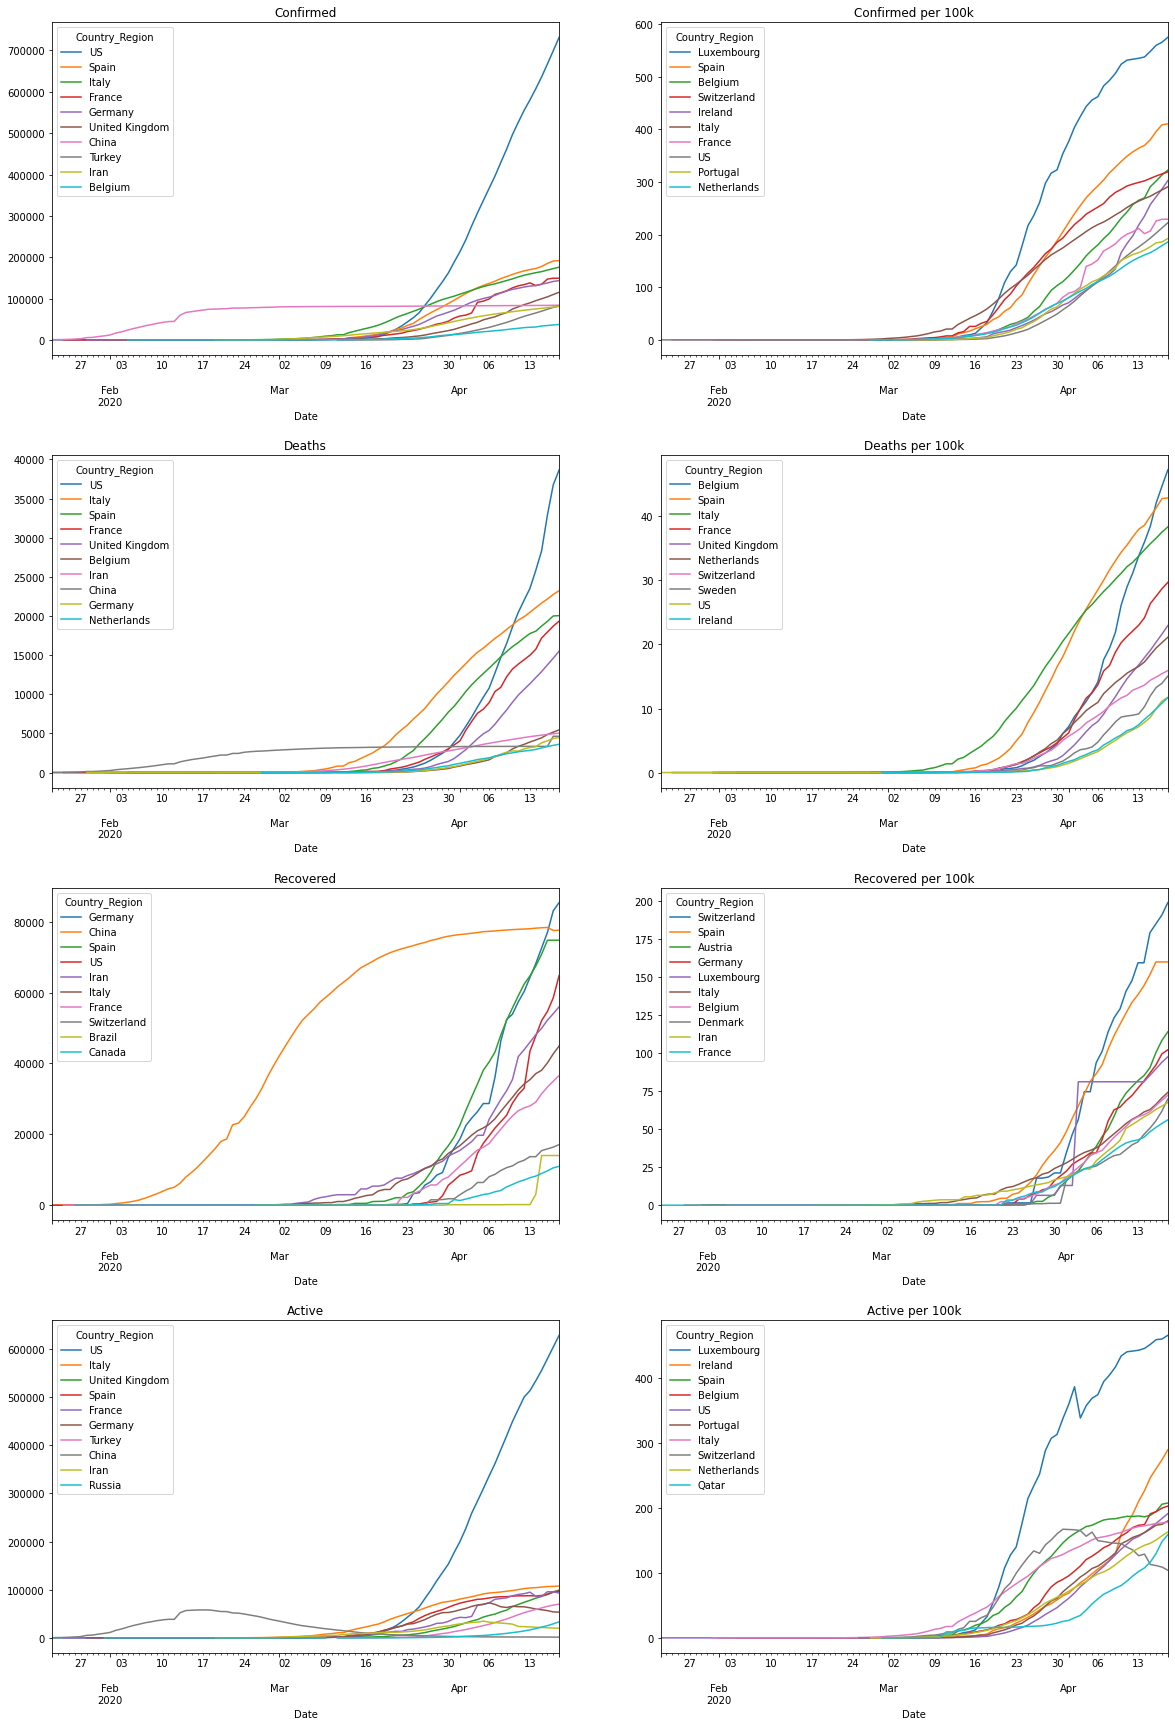

In [36]:
fig, axes = plt.subplots(4, 2, figsize=(20,30))
for i, column in enumerate(covid.columns):
    ax_r = i % 4
    ax_c = int(i/4)
    ax = axes[ax_r, ax_c]
    top_countries = covid_max.nlargest(n=10, columns=column, keep='all').sort_values(by=column, ascending=False).index
    p = covid.loc[top_countries]
    p = p.pivot_table(index=p.index.get_level_values('Date'), 
                      columns=p.index.get_level_values('Country_Region'), 
                      values=column)

    p = p.reindex(columns=top_countries)
    p.plot(title=column.replace('_', ' '), logy=False, ax=ax)

fig.subplots_adjust(hspace=0.3)

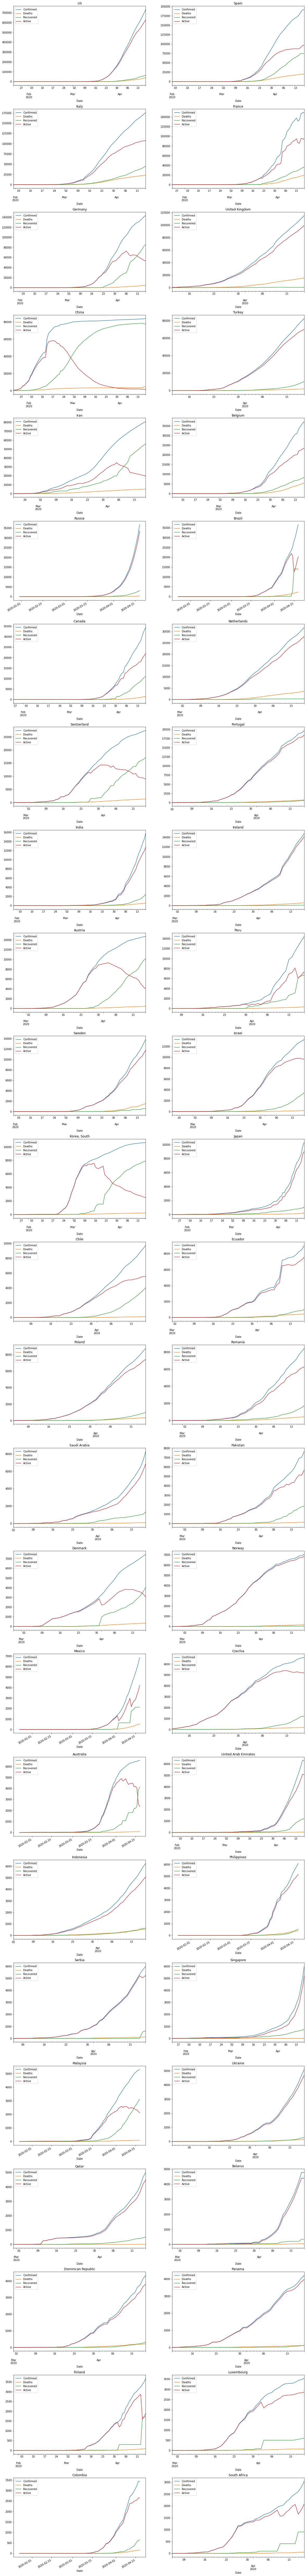

In [37]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country].plot(y=['Confirmed', 'Deaths', 'Recovered', 'Active'], 
                            ax = ax, title=country, logy=False)
    

fig.subplots_adjust(hspace=0.3)

We want to add columns with differences. To smooth the differences we calculate the differences on a rolling window (size 5)

In [38]:
d=covid.groupby(level='Country_Region').rolling(window=5).mean().diff()
d

Confirmed  Deaths  Recovered  \
Country_Region Country_Region Date                                       
Australia      Australia      2020-01-23        NaN     NaN        NaN   
                              2020-01-25        NaN     NaN        NaN   
                              2020-01-26        NaN     NaN        NaN   
                              2020-01-27        NaN     NaN        NaN   
                              2020-01-28        NaN     NaN        NaN   
...                                             ...     ...        ...   
United Kingdom United Kingdom 2020-04-14     5794.6   827.2       -7.2   
                              2020-04-15     4975.6   784.0      -44.0   
                              2020-04-16     4854.2   773.4      -49.4   
                              2020-04-17     4912.6   795.6      -46.4   
                              2020-04-18     5148.8   830.2       22.0   

                                          Active  Confirmed_per_100k  \
Country_Region Country_Region Date                                     
Australia      Australia      2020-01-23     NaN                 NaN   
                              2020-01-25     NaN                 NaN   
                              2020-01-26     NaN                 NaN   
                              2020-01-27     NaN                 NaN   
                              2020-01-28     NaN                 NaN   
...                                          ...                 ...   
United Kingdom United Kingdom 2020-04-14  4974.6            8.580758   
                              2020-04-15  4235.6            7.367967   
                              2020-04-16  4130.2            7.188196   
                              2020-04-17  4163.4            7.274675   
                              2020-04-18  4296.6            7.624445   

                                          Deaths_per_100k  Recovered_per_100k  \
Country_Region Country_Region Date                                              
Australia      Australia      2020-01-23              NaN                 NaN   
                              2020-01-25              NaN                 NaN   
                              2020-01-26              NaN                 NaN   
                              2020-01-27              NaN                 NaN   
                              2020-01-28              NaN                 NaN   
...                                                   ...                 ...   
United Kingdom United Kingdom 2020-04-14         1.224934           -0.010662   
                              2020-04-15         1.160963           -0.065156   
                              2020-04-16         1.145266           -0.073152   
                              2020-04-17         1.178140           -0.068710   
                              2020-04-18         1.229377            0.032578   

                                          Active_per_100k  
Country_Region Country_Region Date                         
Australia      Australia      2020-01-23              NaN  
                              2020-01-25              NaN  
                              2020-01-26              NaN  
                              2020-01-27              NaN  
                              2020-01-28              NaN  
...                                                   ...  
United Kingdom United Kingdom 2020-04-14         7.366486  
                              2020-04-15         6.272160  
                              2020-04-16         6.116082  
                              2020-04-17         6.165245  
                              2020-04-18         6.362490  

[3088 rows x 8 columns]

For some reason the 1st index level is duplicated

In [39]:
d = d.reset_index(level=0, drop=True)
d

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Australia      2020-01-23        NaN     NaN        NaN     NaN   
               2020-01-25        NaN     NaN        NaN     NaN   
               2020-01-26        NaN     NaN        NaN     NaN   
               2020-01-27        NaN     NaN        NaN     NaN   
               2020-01-28        NaN     NaN        NaN     NaN   
...                              ...     ...        ...     ...   
United Kingdom 2020-04-14     5794.6   827.2       -7.2  4974.6   
               2020-04-15     4975.6   784.0      -44.0  4235.6   
               2020-04-16     4854.2   773.4      -49.4  4130.2   
               2020-04-17     4912.6   795.6      -46.4  4163.4   
               2020-04-18     5148.8   830.2       22.0  4296.6   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Australia      2020-01-23                 NaN              NaN   
               2020-01-25                 NaN              NaN   
               2020-01-26                 NaN              NaN   
               2020-01-27                 NaN              NaN   
               2020-01-28                 NaN              NaN   
...                                       ...              ...   
United Kingdom 2020-04-14            8.580758         1.224934   
               2020-04-15            7.367967         1.160963   
               2020-04-16            7.188196         1.145266   
               2020-04-17            7.274675         1.178140   
               2020-04-18            7.624445         1.229377   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Australia      2020-01-23                 NaN              NaN  
               2020-01-25                 NaN              NaN  
               2020-01-26                 NaN              NaN  
               2020-01-27                 NaN              NaN  
               2020-01-28                 NaN              NaN  
...                                       ...              ...  
United Kingdom 2020-04-14           -0.010662         7.366486  
               2020-04-15           -0.065156         6.272160  
               2020-04-16           -0.073152         6.116082  
               2020-04-17           -0.068710         6.165245  
               2020-04-18            0.032578         6.362490  

[3088 rows x 8 columns]

Verify that the rolling values get reset at the country boundaries

In [40]:
len_of_first_group = d.loc[d.index.get_level_values(0)[0]].shape[0]
len_of_first_group

86

In [41]:
d.iloc[len_of_first_group-5:len_of_first_group+10]

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Australia      2020-04-14       61.4     2.2      142.8   -83.6   
               2020-04-15       45.0     1.8       78.6   -35.4   
               2020-04-16       31.8     1.2      109.8   -79.2   
               2020-04-17       41.4     1.2      400.4  -360.2   
               2020-04-18       39.2     1.2      463.6  -425.6   
Austria        2020-02-25        NaN     NaN        NaN     NaN   
               2020-02-26        NaN     NaN        NaN     NaN   
               2020-02-27        NaN     NaN        NaN     NaN   
               2020-02-28        NaN     NaN        NaN     NaN   
               2020-02-29        NaN     NaN        NaN     NaN   
               2020-03-01        2.4     0.0        0.0     2.4   
               2020-03-02        3.2     0.0        0.0     3.2   
               2020-03-03        3.6     0.0        0.0     3.6   
               2020-03-04        5.2     0.0        0.0     5.2   
               2020-03-05        6.4     0.0        0.0     6.4   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Australia      2020-04-14            0.243620         0.008729   
               2020-04-15            0.178549         0.007142   
               2020-04-16            0.126174         0.004761   
               2020-04-17            0.164265         0.004761   
               2020-04-18            0.155536         0.004761   
Austria        2020-02-25                 NaN              NaN   
               2020-02-26                 NaN              NaN   
               2020-02-27                 NaN              NaN   
               2020-02-28                 NaN              NaN   
               2020-02-29                 NaN              NaN   
               2020-03-01            0.026800         0.000000   
               2020-03-02            0.035734         0.000000   
               2020-03-03            0.040201         0.000000   
               2020-03-04            0.058067         0.000000   
               2020-03-05            0.071468         0.000000   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Australia      2020-04-14            0.566595        -0.331704  
               2020-04-15            0.311865        -0.140458  
               2020-04-16            0.435659        -0.314246  
               2020-04-17            1.588687        -1.429184  
               2020-04-18            1.839449        -1.688674  
Austria        2020-02-25                 NaN              NaN  
               2020-02-26                 NaN              NaN  
               2020-02-27                 NaN              NaN  
               2020-02-28                 NaN              NaN  
               2020-02-29                 NaN              NaN  
               2020-03-01            0.000000         0.026800  
               2020-03-02            0.000000         0.035734  
               2020-03-03            0.000000         0.040201  
               2020-03-04            0.000000         0.058067  
               2020-03-05            0.000000         0.071468

In [42]:
covid=covid.join(other=d,rsuffix='_diff')
covid.iloc[80:95]

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Australia      2020-04-13     6351.0    61.0     1806.0  4484.0   
               2020-04-14     6415.0    62.0     2186.0  4167.0   
               2020-04-15     6440.0    63.0     2186.0  4191.0   
               2020-04-16     6462.0    63.0     2355.0  4044.0   
               2020-04-17     6522.0    66.0     3808.0  2648.0   
               2020-04-18     6547.0    67.0     4124.0  2356.0   
Austria        2020-02-25        2.0     0.0        0.0     2.0   
               2020-02-26        2.0     0.0        0.0     2.0   
               2020-02-27        3.0     0.0        0.0     3.0   
               2020-02-28        3.0     0.0        0.0     3.0   
               2020-02-29        9.0     0.0        0.0     9.0   
               2020-03-01       14.0     0.0        0.0    14.0   
               2020-03-02       18.0     0.0        0.0    18.0   
               2020-03-03       21.0     0.0        0.0    21.0   
               2020-03-04       29.0     0.0        0.0    29.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Australia      2020-04-13           25.199181         0.242033   
               2020-04-14           25.453117         0.246001   
               2020-04-15           25.552311         0.249968   
               2020-04-16           25.639601         0.249968   
               2020-04-17           25.877666         0.261872   
               2020-04-18           25.976860         0.265839   
Austria        2020-02-25            0.022334         0.000000   
               2020-02-26            0.022334         0.000000   
               2020-02-27            0.033500         0.000000   
               2020-02-28            0.033500         0.000000   
               2020-02-29            0.100501         0.000000   
               2020-03-01            0.156335         0.000000   
               2020-03-02            0.201003         0.000000   
               2020-03-03            0.234503         0.000000   
               2020-03-04            0.323838         0.000000   

                           Recovered_per_100k  Active_per_100k  \
Country_Region Date                                              
Australia      2020-04-13            7.165757        17.791392   
               2020-04-14            8.673502        16.533615   
               2020-04-15            8.673502        16.628841   
               2020-04-16            9.344052        16.045582   
               2020-04-17           15.109192        10.506602   
               2020-04-18           16.363002         9.348019   
Austria        2020-02-25            0.000000         0.022334   
               2020-02-26            0.000000         0.022334   
               2020-02-27            0.000000         0.033500   
               2020-02-28            0.000000         0.033500   
               2020-02-29            0.000000         0.100501   
               2020-03-01            0.000000         0.156335   
               2020-03-02            0.000000         0.201003   
               2020-03-03            0.000000         0.234503   
               2020-03-04            0.000000         0.323838   

                           Confirmed_diff  Deaths_diff  Recovered_diff  \
Country_Region Date                                                      
Australia      2020-04-13            68.2          2.2           145.2   
               2020-04-14            61.4          2.2           142.8   
               2020-04-15            45.0          1.8            78.6   
               2020-04-16            31.8          1.2           109.8   
               2020-04-17            41.4          1.2           400.4   
               2020-04-18            39.2          1.2           463.6   
Austria        2020-02-25             NaN        

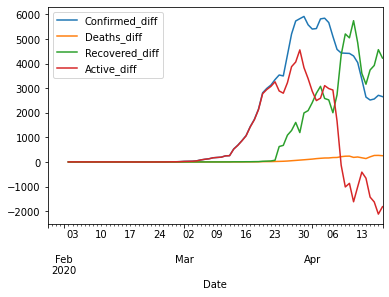

In [43]:
covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].plot()

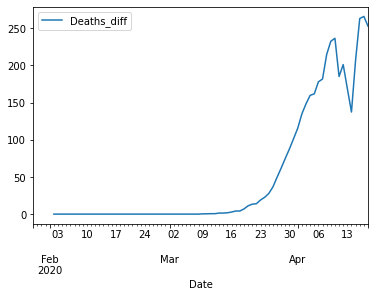

In [44]:
covid.loc[('Germany',),['Deaths_diff']].plot()